# Salary Predictions Based on Job Descriptions

The goal of this project is to develop a model that ingests features like company information, candidate qualification, degree etc to predict the salary of a particular role defined uniquely by a jobId. 

This notebook, however, is an exploartory analysis on the given data set to identify trends and relationships amongst different variables and to get a better undertsanding of the data in itself. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# author info 
__author__ = "Aadithya Ramasubramaniam"
__email__ = "aadithya.viswanath@gmail.com"

### ---- Loading the data ----

In [2]:
# load the data into a Pandas dataframe
Test_Features = pd.read_csv('/Users/raviswanath/Dropbox/data/test_features.csv')
Train_Features = pd.read_csv('/Users/raviswanath/Dropbox/data/train_features.csv')
Train_Salaries = pd.read_csv('/Users/raviswanath/Dropbox/data/train_salaries.csv')

### ---- Data cleaning and exploration ----

In [3]:
Train_Features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
Train_Salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
Train_Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [6]:
Train_Salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [7]:
# merge relevant salary and job features info into a single data set
Training_data = Train_Features.merge(Train_Salaries, on="jobId")

In [8]:
# checking for missing data
Training_data.isnull().sum()/len(Training_data)

jobId                  0.0
companyId              0.0
jobType                0.0
degree                 0.0
major                  0.0
industry               0.0
yearsExperience        0.0
milesFromMetropolis    0.0
salary                 0.0
dtype: float64

### Check and remove outliers

In [9]:
numeric_cols = Training_data.select_dtypes(exclude='object')
categoriacl_cols = Training_data.select_dtypes(exclude=['int64', 'float64'])

In [10]:
[cols for cols in numeric_cols.columns if (numeric_cols[cols] <= 0).any()]

['yearsExperience', 'milesFromMetropolis', 'salary']

In [11]:
Training_data[Training_data.salary <=0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [12]:
Train_Features[Train_Features.yearsExperience < 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [13]:
Train_Features[Train_Features.milesFromMetropolis < 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [14]:
# Removing rows with salary = 0
Training_data = Training_data[Training_data.salary > 0]

In [15]:
Training_data.jobType.value_counts()

SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64

In [16]:
Training_data.groupby(['jobType'])['yearsExperience', 'salary'].median()

,yearsExperience,salary
jobType,,
CEO,12,142
CFO,12,132
CTO,12,132
JANITOR,12,68
JUNIOR,12,92
MANAGER,12,112
SENIOR,12,102
VICE_PRESIDENT,12,122


In [17]:
# Function to remove records which have less than x% of rows in a certain salary range

def remove_extremes(Training_data, tune_param):
    '''Function to remove records which have less than x% of rows in a certain salary range'''
    
    rows_removed = 0
    Job_Types = Training_data.jobType.unique()
    
    for j in Job_Types:
        x = Training_data[Training_data.jobType==j]['salary'].count()
        for i in range(0, 100, 10):
            #identify records in the certain bin for jobType j
            y = Training_data[(Training_data.jobType == j) &
                (Training_data.salary >= np.percentile(Training_data.salary, i)) & 
                (Training_data.salary < np.percentile(Training_data.salary, (i+10)))]['salary'].count()

            if((y/x)*100 < tune_param):
                    # keep count of the number of rows removed
                    rows_removed = rows_removed + y

                    # eliminate the records
                    Training_data = Training_data.loc[~((Training_data.jobType == j)&
                                    (Training_data.salary >= np.percentile(Training_data.salary, i))&
                                    (Training_data.salary < np.percentile(Training_data.salary, (i+10)))),:]
    print(rows_removed)
    return(Training_data)

In [18]:
# Change the tuning parameter here to remove more and more rows. 
Training_data = remove_extremes(Training_data, 2.5)

9587


In [19]:
Training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990408 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  990408 non-null object
companyId              990408 non-null object
jobType                990408 non-null object
degree                 990408 non-null object
major                  990408 non-null object
industry               990408 non-null object
yearsExperience        990408 non-null int64
milesFromMetropolis    990408 non-null int64
salary                 990408 non-null int64
dtypes: int64(3), object(6)
memory usage: 75.6+ MB


In [20]:
# Removing all entries with salaries greater than 250
Training_data = Training_data[Training_data.salary < 250]

In [21]:
Training_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


### ----4 EDA ----

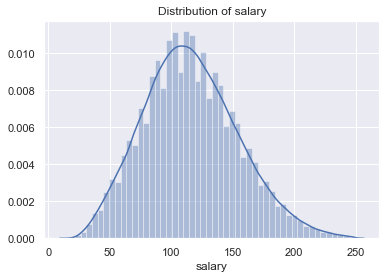

In [22]:
# Distribution of salary 
sns.set(style="darkgrid")
sns.distplot(Training_data.salary)
plt.title("Distribution of salary")
plt.show()

Distribution of salary is almost normal (marginally right skewed) with the long tail extending beyond the 250k mark. 

In [23]:
# correlation between numeric variables
subset = Training_data[['salary', 'yearsExperience', 'milesFromMetropolis']]
subset.corr()

,salary,yearsExperience,milesFromMetropolis
salary,1.000000,0.367124,-0.289967
yearsExperience,0.367124,1.000000,0.012306
milesFromMetropolis,-0.289967,0.012306,1.000000


As one would expect, salary is positively correlated with years of experience. 

Also, the farther the job is located from the metropolis (city), the lower the salary becomes. This is also inline with the intuition that living expenes are usually more in and around the metro and jobs need to be paying higher in the city area to remain attractive.  

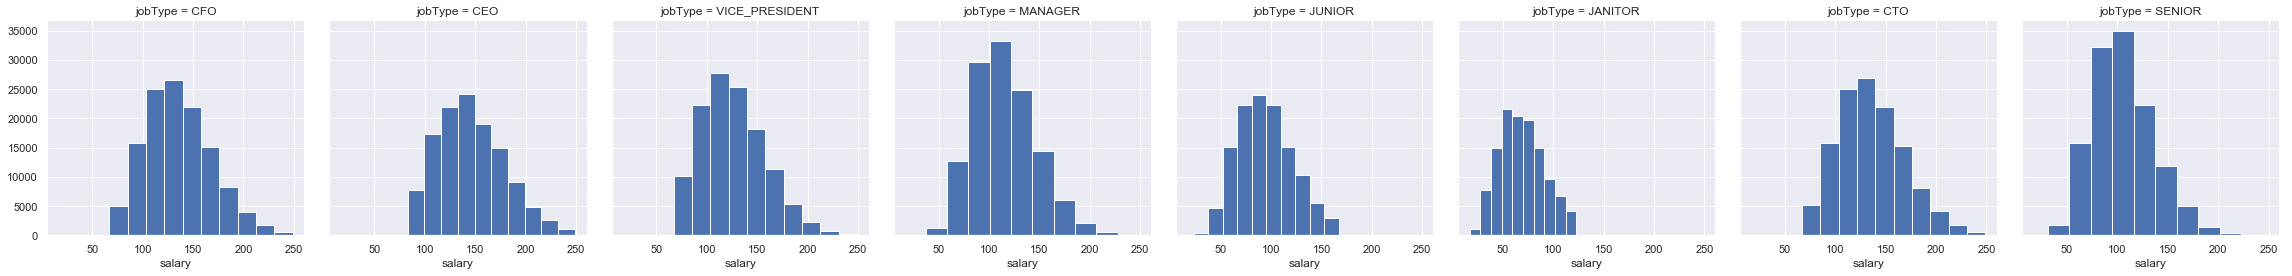

In [24]:
# Pay distribuition across titles
g = sns.FacetGrid(Training_data, col='jobType', height=4)
g = g.map(plt.hist, 'salary', bins=10)

A summary of salary distributions which gives an idea of the salary ranges for each of the job types in our data set. 

CEO's have a right skewed salary distribution with salaries ranging from ~90k to 250k. The same could be said for CFO's, CTO's and VP's, however, the minimum salary for all these positions are significantly lower when compared to the CEO as shown by the plots. 

Janitors have the lowest salary range with some of them making well beyond the 100k mark. One would expect such jobs to be in the heart of a metropolis and requiring a lot of experience. 

In [25]:
# The percentage of each of the job titles in the dataset
(Training_data.jobType.value_counts()/len(Training_data))*100

SENIOR            12.721441
MANAGER           12.642718
CTO               12.585418
CFO               12.519327
VICE_PRESIDENT    12.514173
CEO               12.397756
JUNIOR            12.384113
JANITOR           12.235054
Name: jobType, dtype: float64

The data is uniform across all job types. We have almost equal number of records for the model to be trained on across all positions.

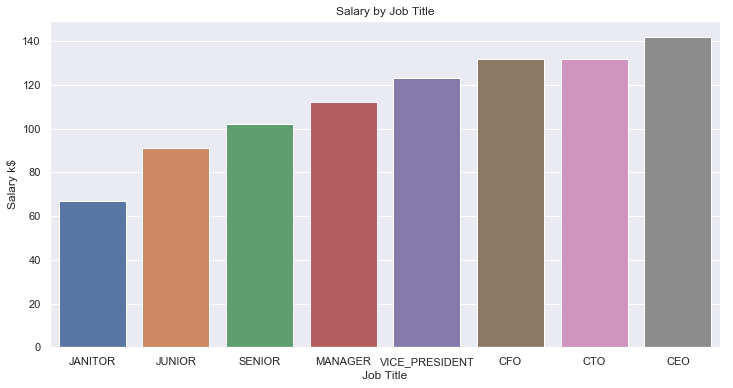

In [26]:
# Median salary by Job Title
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 6
sns.barplot(x='jobType', 
            y='salary',
            data=Training_data.groupby(['jobType'])['salary'].median().reset_index().sort_values(by='salary'))
plt.title('Salary by Job Title')
plt.xlabel('Job Title')
plt.ylabel('Salary k$')
plt.show()

As one would expect, the pay structure grows with the title. CEO's get paid the most (on average) and Janitors the least.

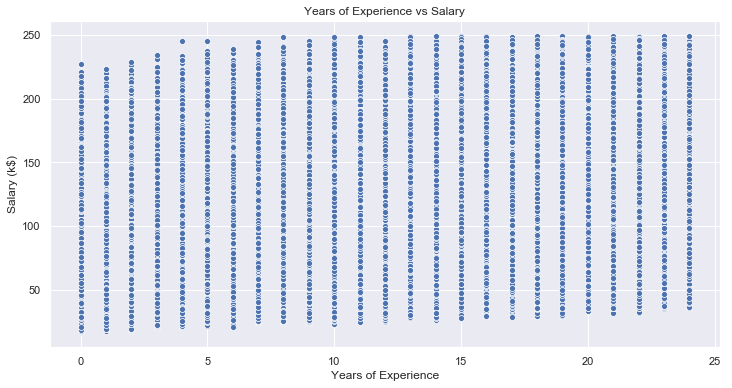

In [27]:
# Relationship between salary and years of experience
sns.scatterplot(x='yearsExperience',
                y='salary',
                data=Training_data)

plt.xlabel("Years of Experience")
plt.ylabel("Salary (k$)")
plt.title("Years of Experience vs Salary")
plt.show()

A gradual shift in the salary levels can be seen as the experience increases which is inline with expectations. 

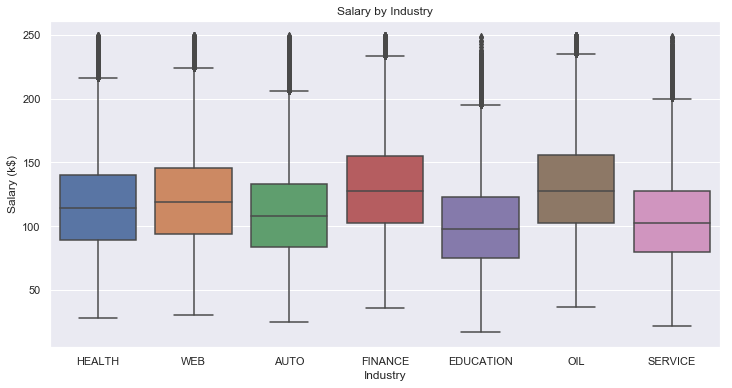

In [28]:
# Avg salary by industry
sns.boxplot(x='industry',
            y='salary',
            data = Training_data)
plt.xlabel('Industry')
plt.ylabel('Salary (k$)')
plt.title("Salary by Industry")
plt.show()

Finance industry jobs pay the highest on average, closely followed by Oil, while Education sector pays the least. 

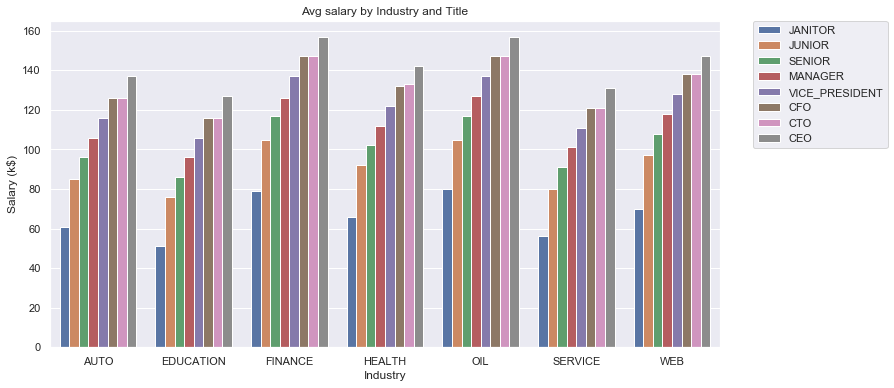

In [29]:
# Avg. Salary by Industry and Title
sns.barplot(x='industry',
            y='salary',
            hue='jobType',
            data=Training_data.groupby(['industry', 
                                        'jobType'])['salary'].median().reset_index().sort_values(['industry',
                                                                                                  'salary'], ascending=True))
plt.xlabel('Industry')
plt.ylabel('Salary (k$)')
plt.title('Avg salary by Industry and Title')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

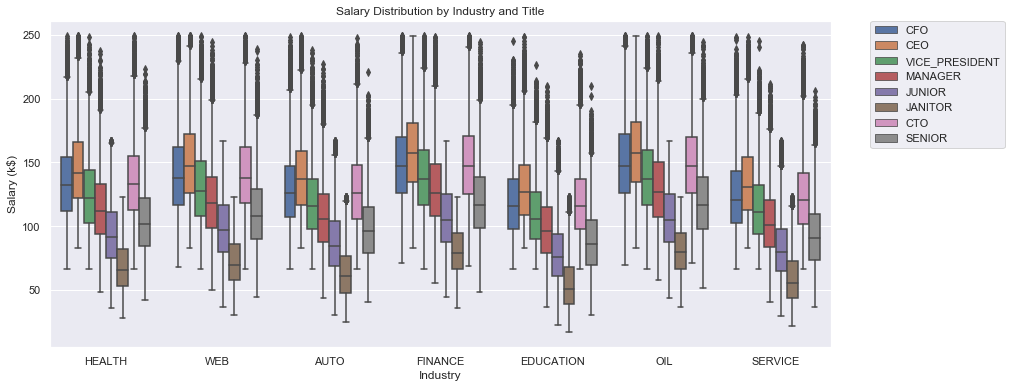

In [30]:
# Distribution of pay by industry and title
rcParams['figure.figsize'] = 14, 6
sns.boxplot(x='industry',
            y='salary',
            hue='jobType',
            data=Training_data)
plt.title('Salary Distribution by Industry and Title')
plt.xlabel('Industry')
plt.ylabel('Salary (k$)')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.)
plt.show()

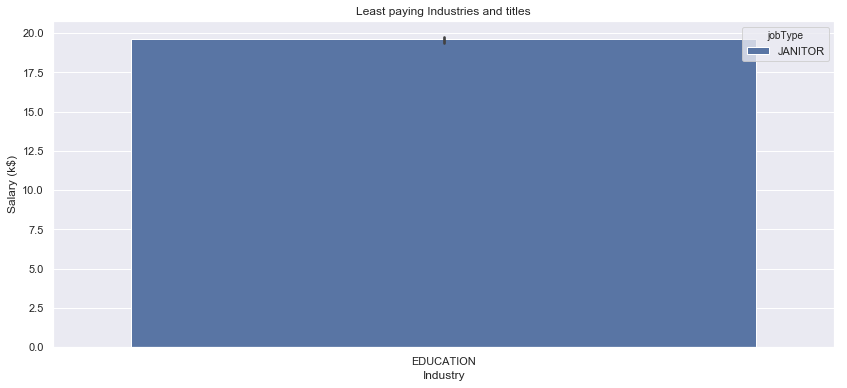

In [31]:
# Least paying industries and titles
sns.barplot(x="industry", 
            y='salary', 
            hue='jobType',
            data=Training_data[['jobType', 'salary', 'industry']].sort_values('salary', ascending=True).head(50))
plt.xlabel('Industry')
plt.ylabel('Salary (k$)')
plt.title('Least paying Industries and titles')
plt.show()

In [32]:
# How important is having a degree to be earning more?
Training_data.degree.value_counts()/ len(Training_data)

HIGH_SCHOOL    0.236233
NONE           0.235220
BACHELORS      0.176515
MASTERS        0.176182
DOCTORAL       0.175851
Name: degree, dtype: float64

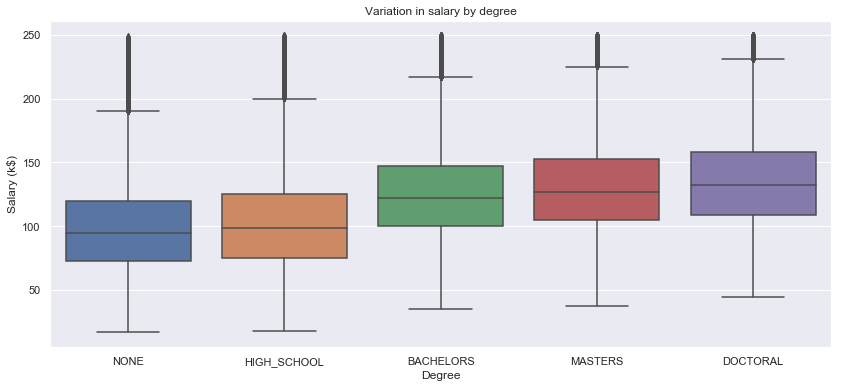

In [33]:
# How important is having a degree to be earning more?
sns.boxplot(x='degree',
            y='salary',
            data = Training_data,
            order = ["NONE", "HIGH_SCHOOL", "BACHELORS", "MASTERS", "DOCTORAL"])
plt.xlabel('Degree')
plt.ylabel('Salary (k$)')
plt.title('Variation in salary by degree')
plt.show()

The above plot clearly shows that having degree helps with getting paid more. The higher the level of degree held, the higher the salary.

However, the same cannot be said for highest pay. At the top level, observations can be found which imply that one need not have a degree at all for earning above 200k.

In [34]:
# But are there C-level executives without even a Bachelor's degree?
Training_data[(Training_data.degree == "NONE") | 
              (Training_data.degree == "HIGH_SCHOOL")].groupby(['jobType'])['salary'].count()

jobType
CEO                48193
CFO                49309
CTO                49453
JANITOR           121071
JUNIOR             49742
MANAGER            49987
SENIOR             49963
VICE_PRESIDENT     48804
Name: salary, dtype: int64

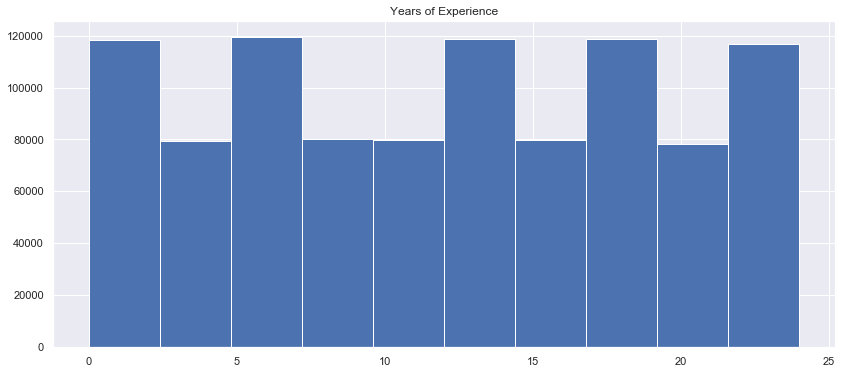

In [35]:
# Distribution of years of experience
Training_data.yearsExperience.hist()
plt.title("Years of Experience")
plt.show()

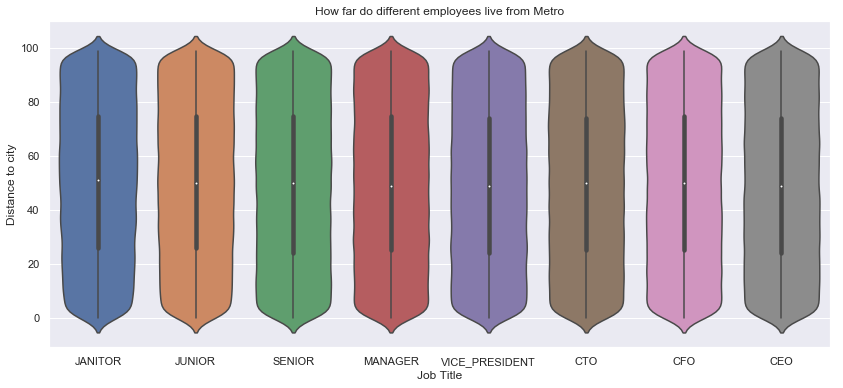

In [36]:
# relationship between job title and distance from Metro
sns.violinplot(x='jobType',
               y='milesFromMetropolis',
               data=Training_data,
               order=['JANITOR','JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT',
                     'CTO', 'CFO', 'CEO'])
plt.title('How far do different employees live from Metro')
plt.xlabel('Job Title')
plt.ylabel('Distance to city')
plt.show()

The dataset has positions uniformly spread across distances.The violin plot above is uniformly stretched out all across for all titles, implying we have almost equal number of records with distance from metro varying between 0 and 100.

In [37]:
# Janitors and Junirs who earn more
Js = ['JANITOR', 'JUNIOR']
Training_data[(Training_data.jobType.isin(Js)) &
             (Training_data.salary >= 100)].groupby(['jobType'])['salary', 'yearsExperience'].mean()

,salary,yearsExperience
jobType,,
JANITOR,109.387384,18.377180
JUNIOR,121.554035,15.356461


In [38]:
# Exce's who earn less
Executives = ["CEO", "CFO", "CTO", "VICE_PRESIDENT"]
Training_data[(Training_data.jobType.isin(Executives)) & 
              (Training_data.salary <= 100)].groupby(['jobType'])['salary', 'yearsExperience'].mean()

,salary,yearsExperience
jobType,,
CEO,93.230579,6.836761
CFO,89.474938,7.169047
CTO,89.465499,7.162604
VICE_PRESIDENT,88.005250,7.888040


In [39]:
# Do a particular major grads earn more as compared to the others?
Training_data.major.value_counts()

NONE           524824
CHEMISTRY       58602
LITERATURE      58505
PHYSICS         58145
BIOLOGY         58138
COMPSCI         58092
BUSINESS        57926
ENGINEERING     57850
MATH            57460
Name: major, dtype: int64

In [40]:
Training_data.degree.value_counts()

HIGH_SCHOOL    233762
NONE           232760
BACHELORS      174669
MASTERS        174339
DOCTORAL       174012
Name: degree, dtype: int64

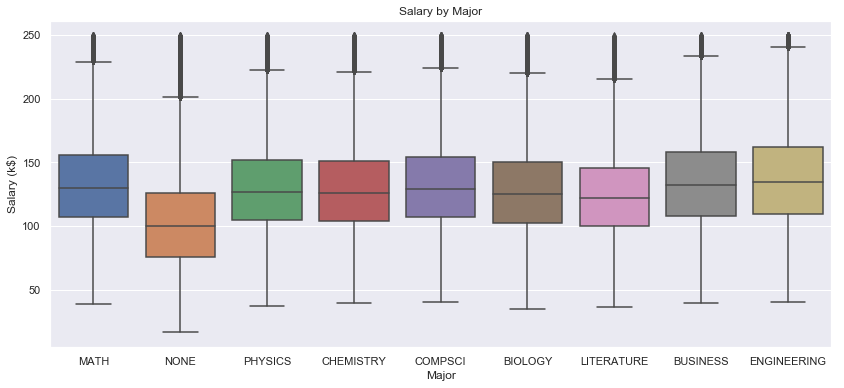

In [41]:
# Do a particular major grads earn more as compared to the others?
sns.boxplot(x='major',
            y='salary',
            data=Training_data)
plt.xlabel('Major')
plt.ylabel('Salary (k$)')
plt.title('Salary by Major')
plt.show()

Having a math, business or engineering degree seems to have strong correlation with getting paid more. All other majors rack up almost at the same level except for Literature. 

This makes sense because it is highly likely that candidates with a literature degree would most likely be employed in the education or health sector, which are low paying industries. 

The NONE segment seems to be a little underpaid overall because the correlation between having no degree and being employed as a Janitor is high.

---